In [78]:
from mangaki.utils.svd import MangakiSVD
from mangaki.utils.als import MangakiALS
from mangaki.utils.pca import MangakiPCA
from mangaki.utils.knn import MangakiKNN
import numpy as np
import pandas
from mangaki.utils.values import rating_values

ratings = pandas.read_csv('../data/ratings-ml.csv', header=None).as_matrix()
works = pandas.read_csv('../data/works-ml.csv', header=None).as_matrix()
tags = pandas.read_csv('../data/tags-ml.csv', header=None).as_matrix()

In [172]:
svd = MangakiALS(2)
X = ratings[:,0:2].astype(int)
# Y = [rating_values[rating] for rating in ratings[:,2]] # Mangaki
Y = [rating for rating in ratings[:,2]] # Movielens
nb_users = X[:,0].max() + 1
nb_items = X[:,1].max() + 1
svd.set_parameters(nb_users,nb_items)
svd.fit(X,Y)

from sklearn.metrics import mean_squared_error
mean_squared_error(svd.predict(X), Y)
# PCA 1.509
# KNN 1.159
# SVD 1.088
# ALS 0.821

Computing M: (671 × 9066)
Shapes (671, 2) (2, 9066)


0.59612951321669694

In [173]:
print(svd.predict(X)[:20])
print(Y[:20])

[ 2.34013435  2.69081481  2.53184354  2.41844951  2.83989374  2.72813424
  2.68948055  2.6550159   2.45027327  2.41487813  2.35583083  2.32479347
  2.63016812  2.59313443  2.7080454   2.60081798  2.5005223   2.2850934
  2.71925507  2.67263106]
[2.5, 3.0, 3.0, 2.0, 4.0, 2.0, 2.0, 2.0, 3.5, 2.0, 2.5, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.5, 1.0, 3.0]


In [174]:
from collections import Counter
movies = Counter(X[:, 1])
popular = []
for work_id, v in movies.most_common(100):
    popular.append(work_id)
    print(works[work_id][1], v, 'votes')
popular.sort()

Forrest Gump (1994) 341 votes
Pulp Fiction (1994) 324 votes
Shawshank Redemption, The (1994) 311 votes
Silence of the Lambs, The (1991) 304 votes
Star Wars: Episode IV - A New Hope (1977) 291 votes
Jurassic Park (1993) 274 votes
Matrix, The (1999) 259 votes
Toy Story (1995) 247 votes
Schindler's List (1993) 244 votes
Terminator 2: Judgment Day (1991) 237 votes
Star Wars: Episode V - The Empire Strikes Back (1980) 234 votes
Braveheart (1995) 228 votes
Back to the Future (1985) 226 votes
Fargo (1996) 224 votes
American Beauty (1999) 220 votes
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) 220 votes
Independence Day (a.k.a. ID4) (1996) 218 votes
Star Wars: Episode VI - Return of the Jedi (1983) 217 votes
Aladdin (1992) 215 votes
Fugitive, The (1993) 213 votes
Dances with Wolves (1990) 202 votes
Fight Club (1999) 202 votes
Seven (a.k.a. Se7en) (1995) 201 votes
Usual Suspects, The (1995) 201 votes
Apollo 13 (1995) 200 votes
Lion King, The (1994) 200 votes
God

In [159]:
"""from scipy.spatial.distance import pdist, squareform

def compute_similarity_coisine(SVD):
    return 1 - squareform(pdist(SVD.T, metric='cosine'))"""

from mangaki.utils import dpplib
svd.VT.shape
#similarity = svd.VT

(2, 9066)

In [160]:
"""limit = 150
A=Work.objects.popular()[:limit]
liste=[np.argwhere(works== A[i].title)[0][0] for i in range(0,limit)]
svd.U.shape"""
svd.VT.shape

(2, 9066)

In [161]:
#liste de 10 éléments choisis en utilisant la dpp
similarity = svd.VT.T.dot(svd.VT)
#sampled_items = dpp.sample_k(liste, similarity, 5)

In [162]:
similarity.shape

(9066, 9066)

In [163]:
L = similarity[np.ix_(popular, popular)]
D, V = np.linalg.eig(L.T)
D = np.real(D)
V = np.real(V)

In [164]:
sampled_items = list(map(lambda x: popular[int(x)], dpplib.sample_k(5, D, V)))
for i in sampled_items:
    print(works[i, 1])

Schindler's List (1993)
American Beauty (1999)
Pulp Fiction (1994)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Indiana Jones and the Last Crusade (1989)


In [165]:
X = svd.VT.T[np.array(sampled_items)]
# 1..-1
# X = svd.VT.T[np.array(sampled_items)[np.array([0, 3, 4, 5, 6, 7, 8, 9])]]

In [166]:
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearRegression

clf = LogisticRegression(fit_intercept=False)
# clf = LinearRegression(fit_intercept=False)
clf.fit(X, [-1, 1, 1, 1, -1])
#pred = clf.coef_[0]
predx, predy = clf.coef_[0][:2]
clf.predict_proba(X)

array([[ 0.49839412,  0.50160588],
       [ 0.49851264,  0.50148736],
       [ 0.49768575,  0.50231425],
       [ 0.49927133,  0.50072867],
       [ 0.49939588,  0.50060412]])

In [167]:
#clf.coef_
predx, predy

(0.065875352537949308, 0.016025470321136943)

<IPython.core.display.Javascript object>


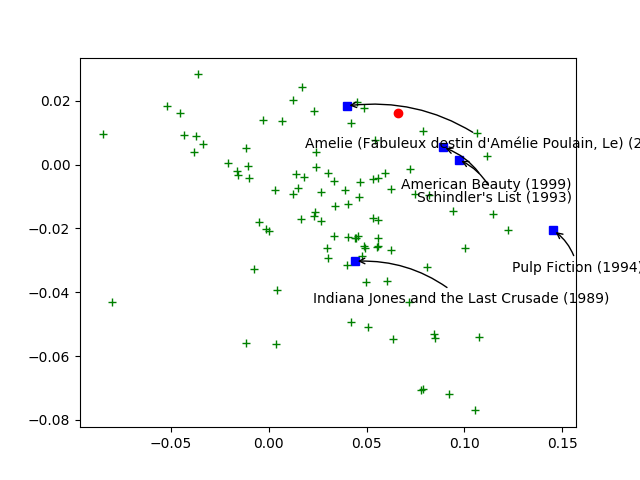

In [168]:
%matplotlib notebook
import matplotlib.pyplot as plt

class MangakiViz:
    label = None
    def __init__(self, titles, coords, drawn, featured):
        fig = plt.figure()
        self.label = {}
        for p_id in drawn:
            x, y = coords[p_id, 0], coords[p_id, 1]
            self.label[(x, y)] = titles[p_id]
            if p_id in featured:
                plt.plot(x, y, 'sb')  # Special points
                self.display(x, y)
            else:
                plt.plot(x, y, '+g', picker=5)
        # plt.plot(jjx, jjy, 'or')
        # plt.plot(predx, predy, 'og')
        fig.canvas.mpl_connect('pick_event', self.onpick)
    
    def display(self, x, y):
        plt.annotate(self.label[(x, y)], xy=(x, y), xycoords='data',
            xytext=(-30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=.2")
            )
    
    def where_am_i(self, point):
        plt.plot(point[0], point[1], 'or')
    
    def draw_history(self, history):
        plt.plot(history[:, 0], history[:, 1], 'og')
    
    def onpick(self, event):
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind
        points = tuple(zip(xdata[ind], ydata[ind]))
        x, y = points[0]
        self.display(x, y)

titles = works[:, 1].tolist()
viz = MangakiViz(titles, svd.VT.T, popular, sampled_items)
# viz.where_am_i((-0.61951029531106994, -0.15674103238147402))  # Old Ryan
viz.where_am_i((clf.coef_[0][:2]))

In [147]:
svd.VT = svd.VT_

AttributeError: 'MangakiALS' object has no attribute 'VT_'

In [175]:
titles = works[:, 1].tolist()
contestants = list(zip(range(len(titles)), titles, clf.predict_proba(svd.VT.T)))
# contestants.sort(key=lambda x: abs(x[2][1] - 0.5))
contestants.sort(key=lambda x: x[2][0])

In [176]:
contestants[:150]  # Hai to Gensou no Grimgar

[(8491, 'Hunted, The (2003)', array([ 0.44053528,  0.55946472])),
 (3029, 'Horror Express (1972)', array([ 0.44718003,  0.55281997])),
 (4685, 'Darkness Falls (2003)', array([ 0.44777902,  0.55222098])),
 (3226,
  'King Kong vs. Godzilla (Kingukongu tai Gojira) (1962)',
  array([ 0.45169742,  0.54830258])),
 (3303, 'Million Dollar Hotel, The (2001)', array([ 0.45315402,  0.54684598])),
 (8994,
  'Heidi Fleiss: Hollywood Madam (1995)',
  array([ 0.45328281,  0.54671719])),
 (5347, 'Baby Boy (2001)', array([ 0.45358783,  0.54641217])),
 (4306, 'Whore (1991)', array([ 0.45378833,  0.54621167])),
 (5119, 'So Fine (1981)', array([ 0.45378833,  0.54621167])),
 (5483, 'Last Exit to Brooklyn (1989)', array([ 0.45378833,  0.54621167])),
 (4147,
  'Red Sorghum (Hong gao liang) (1987)',
  array([ 0.45386723,  0.54613277])),
 (6328, 'Romance (1999)', array([ 0.45427899,  0.54572101])),
 (533, 'Santa Claus: The Movie (1985)', array([ 0.45469347,  0.54530653])),
 (4570, 'Tunnel, The (Tunnel, Der) (2

In [177]:
class Data:
    def __init__(self):
        self.sampled_items = sampled_items.tolist()
        # self.X = svd.VT.T[self.sampled_items]
        self.y = [0, 1, 1, 1, 1]
    
    def get_all_ratings(self):
        self.sampled_items = []
        self.y = []
        rating_values = {'favorite': 1, 'like': 1}
        for user_id, work_id, choice in ratings:
            if user_id == JJ:
                self.sampled_items.append(work_id)
                self.y.append(rating_values.get(choice, 0))
        self.X = svd.VT.T[self.sampled_items]
        print(len(self.X), 'ratings')

    def add(self, extra):
        for work_id, outcome in extra:
            self.sampled_items.append(work_id)
            self.y.append(outcome)
        self.X = svd.VT.T[self.sampled_items]

# extra = [(332, 1), (2060, 1), (7726, 1)]
ryan = Data()
# ryan.add(extra)
ryan.get_all_ratings()
clf.fit(ryan.X, ryan.y)

AttributeError: 'list' object has no attribute 'tolist'

In [178]:
import pprint

i = 1
contestants = list(zip(titles, svd.VT[i, :]))
contestants.sort(key=lambda x: x[1])
print('Bottom 20')
pprint.pprint(contestants[:20])
print('Top 20')
pprint.pprint(contestants[-20:])

Bottom 20
[('Vampyros Lesbos (Vampiras, Las) (1971)', -2.3619096404367079),
 ('Dylan Moran: Monster (2004)', -2.3619096404367079),
 ('Play House, The (1921)', -2.3003452918421923),
 ('Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) '
  '(1971)',
  -2.3003452918421923),
 ('Goat, The (1921)', -2.3003452918421923),
 ('Cops (1922)', -2.3003452918421923),
 ('Ben X (2007)', -2.1260432790636079),
 ('Lake of Fire (2006)', -2.1260432790636079),
 ("Dead Man's Shoes (2004)", -2.1033270138320148),
 ('Eat Pray Love (2010)', -1.9777044498937313),
 ('Innocence (2000)', -1.9492952403527017),
 ('Maelström (2000)', -1.9492952403527017),
 ('King Is Alive, The (2000)', -1.9492952403527017),
 ("Razor's Edge, The (1946)", -1.8517409302431367),
 ('Excision (2012)', -1.8237292863572128),
 ('Day of the Beast, The (Día de la Bestia, El) (1995)', -1.7647261076197307),
 ('Bone Tomahawk (2015)', -1.7537899686410352),
 ('Bobby (2006)', -1.7484170821039848),
 ('Hair (1979)', -1.7484170821039848

In [171]:
i = 0
likes = Counter()
hates = Counter()
for j, v in enumerate(svd.VT[i, :]):
    for tag in tags[j, 1].split('|'):
        if v > 0:
            likes[tag] += v
        else:
            hates[tag] -= v
print('LIKES')
print(likes)
print('HATES')
print(hates)

LIKES
Counter({'Drama': 13.105194297553684, 'Comedy': 7.0730350978761649, 'Thriller': 5.1861700561138511, 'Crime': 4.7297022669874327, 'Action': 4.2679788948674711, 'Romance': 3.8293096410417533, 'Adventure': 3.5370896231710054, 'Sci-Fi': 2.5377833695445999, 'Mystery': 2.0674996391231049, 'Fantasy': 1.7459561370566026, 'War': 1.5072340106266549, 'Horror': 1.349242759461351, 'Children': 1.2896044268605205, 'Documentary': 1.1683574800376937, 'Animation': 1.1211302070188105, 'Musical': 0.94259397198620665, 'Film-Noir': 0.66368330531475361, 'IMAX': 0.52084233953606673, 'Western': 0.45459402300399282, '(no genres listed)': 0.0091965381445955306})
HATES
Counter({'Comedy': 10.530207140541702, 'Action': 7.3023118608326243, 'Drama': 7.2312082344184256, 'Thriller': 5.8600893118434954, 'Adventure': 4.6056229529125279, 'Romance': 4.2780478117221543, 'Sci-Fi': 4.0308403687324956, 'Crime': 2.8020736037256935, 'Horror': 2.4758074630552436, 'Fantasy': 2.3892405346239247, 'Children': 1.9130153794475093